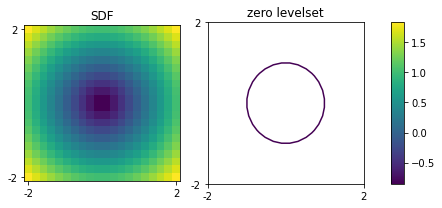

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
import functools as ft
import optax
import treex as tx
from sdf_jax import plot2d, discretize2d
from sdf_jax import SimpleNeuralSDF, train_step, print_callback


def sdf_sphere(x):
    return jnp.linalg.norm(x) - 1

plot2d(sdf_sphere, ngrid=20)

In [2]:
def fit(
    sdf=sdf_sphere,
    ngrid=20,
    # module
    dims=[64,64],
    act=jax.nn.relu,
    # optimizer
    key=jrandom.PRNGKey(1234),
    lr=5e-3,
    steps=100,
    # utils
    cb=print_callback,
    cb_every=10,
):
    xs, ys = discretize2d(sdf, xy_lims=(-2, 2), ngrid=ngrid)
    xs = xs.reshape(-1, 2)
    ys = ys.reshape(-1)
    key, model_key = jrandom.split(key, 2)
    model = SimpleNeuralSDF(dims=dims, act=act).init(model_key, xs[0])
    optimizer = tx.Optimizer(optax.adam(lr))
    optimizer = optimizer.init(model.filter(tx.Parameter))
    for step in range(steps):
        loss, model, optimizer = train_step(model, xs, ys, optimizer)
        if step % cb_every == 0:
            cb(step, loss, model, optimizer)
    return loss, model

In [3]:
loss, model = fit()

[0] loss: 1.1152
[10] loss: 0.9029
[20] loss: 0.7112
[30] loss: 0.5532
[40] loss: 0.3154
[50] loss: 0.2288
[60] loss: 0.1458
[70] loss: 0.1557
[80] loss: 0.1747
[90] loss: 0.1599


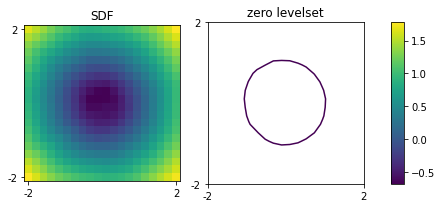

In [5]:
plot2d(model, ngrid=20)

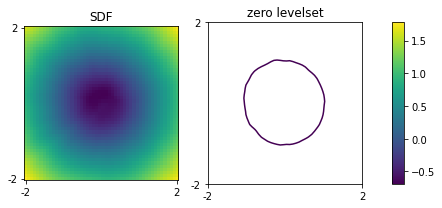

In [4]:
plot2d(model, ngrid=50)

[0] loss: 1.3369
[10] loss: 1.6699
[20] loss: 1.0616
[30] loss: 1.0051
[40] loss: 0.8315
[50] loss: 0.6744
[60] loss: 0.5606
[70] loss: 0.4259
[80] loss: 0.4308
[90] loss: 0.4128


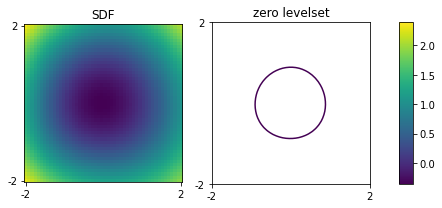

In [6]:
loss, model = fit(act=jax.nn.softplus)
plot2d(model, ngrid=50)

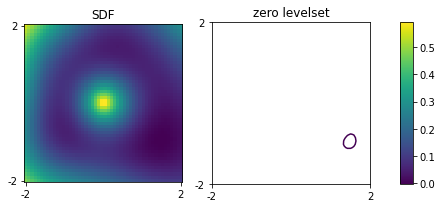

In [7]:
plot2d(lambda x: model(x) - sdf_sphere(x), ngrid=50)